In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss
from sklearn.metrics import mean_absolute_error

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("darkgrid", {"axes.edgecolor": 'black'})

# import models in ../scripts
import sys
sys.path.append("../scripts/")
from models import RandomFourierFeatureNetwork, SIREN
from datasets import OOIDASDataset

/home/niyiyu/anaconda3/envs/seisml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load data

In [2]:
DR_PATH = f"/fd1/yiyu_data/OOI/OOI-training-15min-demean-15-29-XMIN25000-XMAX40000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw'][::8,::8]
TRAIN_DATA -= TRAIN_DATA.min()
TRAIN_DATA /= abs(TRAIN_DATA).max()

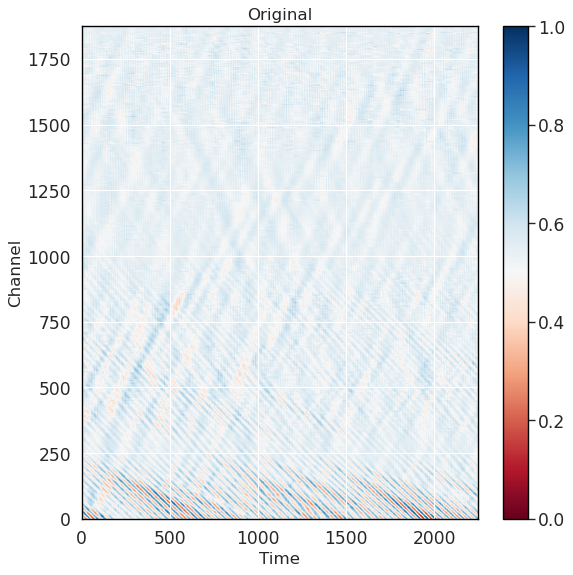

In [3]:
fig = plt.figure(figsize = (8, 8), dpi = 80)
plt.imshow(TRAIN_DATA[:, :], cmap = 'RdBu', aspect = 'auto', origin='lower')
plt.title("Original", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar()

## preprocessing data and send to data loader

In [18]:
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); X = x/(NX-1)

# RFFN
n_feature = 196
B = np.random.normal(scale = 20, size = (n_feature, 2))
Bv = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)@B.T
all_data_rffn = np.concatenate([np.cos(2*np.pi*Bv), np.sin(2*np.pi*Bv), TRAIN_DATA.reshape([-1, 1])], axis = -1)

# SIREN
all_data_siren = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1]), TRAIN_DATA.reshape([-1, 1])], axis = -1)

dataset_rffn = OOIDASDataset(all_data_rffn[:, :-1], np.expand_dims(all_data_rffn[:, -1], axis = -1))
data_loader_rffn = DataLoader(dataset_rffn, batch_size=1024*8, shuffle=True, num_workers=10)

dataset_siren = OOIDASDataset(all_data_siren[:, :-1], np.expand_dims(all_data_siren[:, -1], axis = -1))
data_loader_siren = DataLoader(dataset_siren, batch_size=1024*8, shuffle=True, num_workers = 10)

## defind model and initize the weights

In [86]:
device = torch.device('cuda')
n_layers = 4
model_rffn = RandomFourierFeatureNetwork(n_feature, n_layers=n_layers)
for i in model_rffn.modules():
    if isinstance(i, torch.nn.Linear):
        i.weight.data.normal_(mean=0.0, std=0.1)
        i.bias.data.normal_(mean=0.0, std=0.1)

model_rffn.to(device);

In [87]:
device = torch.device('cuda')
n_units = 128
n_layers = 20
n_input = 2
n_output = 1
omega = 30
model_siren = SIREN(n_input = n_input, 
              n_output = n_output, 
              n_layers = n_layers, 
              n_units = n_units, 
              omega = omega)

for name, mod in model_siren.named_parameters():
    if "inputs" in name:     # for input layer
        if 'bias' in name:
            mod.data.uniform_(-1/np.sqrt(n_input), 1/np.sqrt(n_input))
        elif 'weight' in name:
            mod.data.uniform_(-1/2, 1/2)
    else:                    # for hidden layer
        if 'bias' in name: 
            mod.data.uniform_(-1/np.sqrt(n_units), 1/np.sqrt(n_units))
        elif 'weight' in name:
            mod.data.uniform_(-np.sqrt(6/n_units)/omega, np.sqrt(6/n_units)/omega) 
            
model_siren.to(device);

In [88]:
n_weights = 0
for model in [model_rffn, model_siren]:
    for i in model.parameters():
        n_weights += len(i.data.flatten())
    print(f"{model.__class__}:\n\t\t- {n_weights} weights")

<class 'models.RandomFourierFeatureNetwork'>:
		- 231673 weights
<class 'models.SIREN'>:
		- 562426 weights


## training

In [89]:
x1, x2, y1, y2 = 200, 600, 50, 350

all_data_rffn_2d = all_data_rffn.reshape(NX, NT, n_feature*2+1)[:, :, :n_feature*2]
predict_rffn = np.ones([NX, NT]) * 0.5
mse_rffn = mean_absolute_error(TRAIN_DATA, predict_rffn)

all_data_siren_2d = all_data_siren.reshape(NX, NT, 3)[:, :, :2]
predict_siren = np.ones([NX, NT]) * 0.5
mse_siren = mean_absolute_error(TRAIN_DATA, predict_siren)

plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.title("Original Data")
plt.xticks([]); plt.yticks([]);

# inset axes....
axins = plt.gca().inset_axes([0.6, 0.6, 0.35, 0.35])
axins.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
# sub region of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid(False)
axins.set_xticklabels([])
axins.set_yticklabels([])
plt.gca().indicate_inset_zoom(axins, edgecolor="black")

plt.subplot(1,3,2)
plt.imshow(predict_rffn, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.text(50, 1750, "MSE %.6f" % mse_rffn, color = 'r')
plt.title("Epoch 0\nRFFN Reconstructed")
plt.xticks([]); plt.yticks([]);

# inset axes....
axins = plt.gca().inset_axes([0.6, 0.6, 0.35, 0.35])
axins.imshow(predict_rffn, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
# sub region of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid(False)
axins.set_xticklabels([])
axins.set_yticklabels([])
plt.gca().indicate_inset_zoom(axins, edgecolor="black")

plt.subplot(1,3,3)
plt.imshow(predict_siren, cmap = 'RdBu', aspect = 'auto', origin='lower',
          vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.text(50, 1750, "MSE %.6f" % mse_siren, color = 'r')
plt.title("SIREN Reconstructed")
plt.xticks([]); plt.yticks([]);

# inset axes....
axins = plt.gca().inset_axes([0.6, 0.6, 0.35, 0.35])
axins.imshow(predict_siren, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
# sub region of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid(False)
axins.set_xticklabels([])
axins.set_yticklabels([])
plt.gca().indicate_inset_zoom(axins, edgecolor="black")

plt.savefig(f"./figures/predict_00.png", bbox_inches = 'tight')
plt.close()

In [90]:
lr = 4e-5
optimizer_siren = torch.optim.Adam(model_siren.parameters(), lr = lr)
optimizer_rffn = torch.optim.Adam(model_rffn.parameters(), lr = lr*3)
loss_fn = MSELoss()

In [91]:
nepoch = 40
train_losses = np.zeros([nepoch, 2])

model_rffn.train()
model_siren.train()
for epoch in range(nepoch):
    print(f"Epoch {epoch+1}")
    
    ## train. rFFN then SIREN
    for imodel, (model, optimizer, data_loader) in enumerate(zip([model_rffn, model_siren], 
                                [optimizer_rffn, optimizer_siren],
                                [data_loader_rffn, data_loader_siren])):
        train_loss = 0
        for batch_id, batch in tqdm(enumerate(data_loader), total = len(data_loader)):
            pred = model(batch[0].to(device))
            loss = loss_fn(pred, batch[1].to(device))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(data_loader)
        train_losses[epoch, imodel] = train_loss
    print("train loss. RFFN: %.6f, SIREN: %.6f"  % (train_losses[epoch, 0], train_losses[epoch, 1]))
    
    npiece = 5
    for i in range(npiece):
        _gpu_predict = model_rffn(torch.Tensor(all_data_rffn_2d[i*375:(i+1)*375, :, :].reshape(-1, n_feature*2)).to(device)).reshape(375, NT)
        predict_rffn[i*375:(i+1)*375, :] = _gpu_predict.detach().cpu().numpy()
        _gpu_predict = model_siren(torch.Tensor(all_data_siren_2d[i*375:(i+1)*375, :, :].reshape(-1, 2)).to(device)).reshape(375, NT)
        predict_siren[i*375:(i+1)*375, :] = _gpu_predict.detach().cpu().numpy()
        torch.cuda.empty_cache()
    
    
    mse_rffn = mean_absolute_error(TRAIN_DATA, predict_rffn)
    mse_siren = mean_absolute_error(TRAIN_DATA, predict_siren)
    
    plt.figure(figsize = (18, 6))
    plt.subplot(1,3,1)
    plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
               vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
    plt.title("Original Data")
    plt.xticks([]); plt.yticks([]);
    
    # inset axes....
    axins = plt.gca().inset_axes([0.6, 0.6, 0.35, 0.35])
    axins.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
               vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
    # sub region of the original image
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.grid(False)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    plt.gca().indicate_inset_zoom(axins, edgecolor="black")

    plt.subplot(1,3,2)
    plt.imshow(predict_rffn, cmap = 'RdBu', aspect = 'auto', origin='lower', 
               vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
    plt.text(50, 1750, "MSE %.6f" % mse_rffn, color = 'r')
    plt.title(f"Epoch {epoch+1}\nRFFN Reconstructed")
    plt.xticks([]); plt.yticks([]);
    
    # inset axes....
    axins = plt.gca().inset_axes([0.6, 0.6, 0.35, 0.35])
    axins.imshow(predict_rffn, cmap = 'RdBu', aspect = 'auto', origin='lower', 
               vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
    # sub region of the original image
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.grid(False)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    plt.gca().indicate_inset_zoom(axins, edgecolor="black")

    plt.subplot(1,3,3)
    plt.imshow(predict_siren, cmap = 'RdBu', aspect = 'auto', origin='lower',
              vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
    plt.text(50, 1750, "MSE %.6f" % mse_siren, color = 'r')
    plt.title("SIREN Reconstructed")
    plt.xticks([]); plt.yticks([]);
    
    # inset axes....
    axins = plt.gca().inset_axes([0.6, 0.6, 0.35, 0.35])
    axins.imshow(predict_siren, cmap = 'RdBu', aspect = 'auto', origin='lower', 
               vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
    # sub region of the original image
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.grid(False)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    plt.gca().indicate_inset_zoom(axins, edgecolor="black")
    
    plt.savefig(f"./figures/predict_{str(epoch+1).zfill(2)}.png", bbox_inches = 'tight')
    plt.close()

Epoch 1


100%|██████████| 515/515 [00:07<00:00, 72.77it/s] 


train loss. RFFN: 0.004247, SIREN: 0.002549
Epoch 2


100%|██████████| 515/515 [00:07<00:00, 71.99it/s] 


train loss. RFFN: 0.002365, SIREN: 0.002435
Epoch 3


100%|██████████| 515/515 [00:06<00:00, 79.16it/s] 


train loss. RFFN: 0.001897, SIREN: 0.002208
Epoch 4


100%|██████████| 515/515 [00:07<00:00, 71.49it/s] 


train loss. RFFN: 0.001514, SIREN: 0.001744
Epoch 5


100%|██████████| 515/515 [00:06<00:00, 82.60it/s] 


train loss. RFFN: 0.001254, SIREN: 0.001461
Epoch 6


100%|██████████| 515/515 [00:06<00:00, 83.66it/s] 


train loss. RFFN: 0.001100, SIREN: 0.001282
Epoch 7


100%|██████████| 515/515 [00:06<00:00, 77.82it/s] 


train loss. RFFN: 0.001011, SIREN: 0.001195
Epoch 8


100%|██████████| 515/515 [00:06<00:00, 85.45it/s] 


train loss. RFFN: 0.000954, SIREN: 0.001151
Epoch 9


100%|██████████| 515/515 [00:06<00:00, 78.84it/s] 


train loss. RFFN: 0.000916, SIREN: 0.001135
Epoch 10


100%|██████████| 515/515 [00:05<00:00, 91.95it/s] 


train loss. RFFN: 0.000885, SIREN: 0.001120
Epoch 11


100%|██████████| 515/515 [00:05<00:00, 95.38it/s] 


train loss. RFFN: 0.000863, SIREN: 0.001117
Epoch 12


100%|██████████| 515/515 [00:05<00:00, 87.50it/s] 


train loss. RFFN: 0.000845, SIREN: 0.001105
Epoch 13


100%|██████████| 515/515 [00:06<00:00, 83.84it/s] 


train loss. RFFN: 0.000830, SIREN: 0.001091
Epoch 14


100%|██████████| 515/515 [00:05<00:00, 86.99it/s] 


train loss. RFFN: 0.000817, SIREN: 0.001093
Epoch 15


100%|██████████| 515/515 [00:06<00:00, 74.80it/s] 


train loss. RFFN: 0.000807, SIREN: 0.001080
Epoch 16


100%|██████████| 515/515 [00:05<00:00, 89.89it/s] 


train loss. RFFN: 0.000795, SIREN: 0.001083
Epoch 17


100%|██████████| 515/515 [00:05<00:00, 87.91it/s] 


train loss. RFFN: 0.000787, SIREN: 0.001080
Epoch 18


100%|██████████| 515/515 [00:06<00:00, 83.27it/s] 


train loss. RFFN: 0.000780, SIREN: 0.001070
Epoch 19


100%|██████████| 515/515 [00:05<00:00, 85.89it/s] 


train loss. RFFN: 0.000773, SIREN: 0.001068
Epoch 20


100%|██████████| 515/515 [00:06<00:00, 83.04it/s] 


train loss. RFFN: 0.000766, SIREN: 0.001067
Epoch 21


100%|██████████| 515/515 [00:05<00:00, 87.56it/s] 


train loss. RFFN: 0.000760, SIREN: 0.001069
Epoch 22


100%|██████████| 515/515 [00:05<00:00, 90.57it/s] 


train loss. RFFN: 0.000754, SIREN: 0.001064
Epoch 23


100%|██████████| 515/515 [00:06<00:00, 79.24it/s] 


train loss. RFFN: 0.000750, SIREN: 0.001060
Epoch 24


100%|██████████| 515/515 [00:06<00:00, 76.12it/s] 


train loss. RFFN: 0.000745, SIREN: 0.001055
Epoch 25


100%|██████████| 515/515 [00:06<00:00, 75.76it/s] 


train loss. RFFN: 0.000740, SIREN: 0.001053
Epoch 26


100%|██████████| 515/515 [00:06<00:00, 83.55it/s] 


train loss. RFFN: 0.000737, SIREN: 0.001056
Epoch 27


100%|██████████| 515/515 [00:05<00:00, 88.29it/s] 


train loss. RFFN: 0.000733, SIREN: 0.001059
Epoch 28


100%|██████████| 515/515 [00:06<00:00, 78.28it/s] 


train loss. RFFN: 0.000729, SIREN: 0.001046
Epoch 29


100%|██████████| 515/515 [00:05<00:00, 98.89it/s] 


train loss. RFFN: 0.000726, SIREN: 0.001048
Epoch 30


100%|██████████| 515/515 [00:05<00:00, 87.23it/s] 


train loss. RFFN: 0.000722, SIREN: 0.001045
Epoch 31


100%|██████████| 515/515 [00:06<00:00, 82.17it/s] 


train loss. RFFN: 0.000719, SIREN: 0.001045
Epoch 32


100%|██████████| 515/515 [00:05<00:00, 90.00it/s] 


train loss. RFFN: 0.000716, SIREN: 0.001045
Epoch 33


100%|██████████| 515/515 [00:05<00:00, 100.08it/s]


train loss. RFFN: 0.000714, SIREN: 0.001064
Epoch 34


100%|██████████| 515/515 [00:06<00:00, 80.07it/s] 


train loss. RFFN: 0.000711, SIREN: 0.001051
Epoch 35


100%|██████████| 515/515 [00:06<00:00, 85.02it/s] 


train loss. RFFN: 0.000708, SIREN: 0.001032
Epoch 36


100%|██████████| 515/515 [00:06<00:00, 79.54it/s] 


train loss. RFFN: 0.000707, SIREN: 0.001035
Epoch 37


100%|██████████| 515/515 [00:05<00:00, 91.58it/s] 


train loss. RFFN: 0.000703, SIREN: 0.001037
Epoch 38


100%|██████████| 515/515 [00:05<00:00, 100.50it/s]


train loss. RFFN: 0.000702, SIREN: 0.001037
Epoch 39


100%|██████████| 515/515 [00:06<00:00, 81.58it/s] 


train loss. RFFN: 0.000699, SIREN: 0.001037
Epoch 40


100%|██████████| 515/515 [00:06<00:00, 83.80it/s] 


train loss. RFFN: 0.000697, SIREN: 0.001027


In [ ]:
plt.figure(figsize = (10, 5), dpi = 80)
plt.plot(np.arange(1, 40 + 1), train_losses[:, 0], marker = "o", label = 'Random FFN', linewidth = 3)
plt.plot(np.arange(1, 40 + 1), train_losses[:, 1], marker = "o", label = 'SIREN', linewidth = 3)
plt.xlim([0.8, 40])
plt.legend()
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig(f"./figures/loss_{epoch}.png", bbox_inches = 'tight')
plt.close()

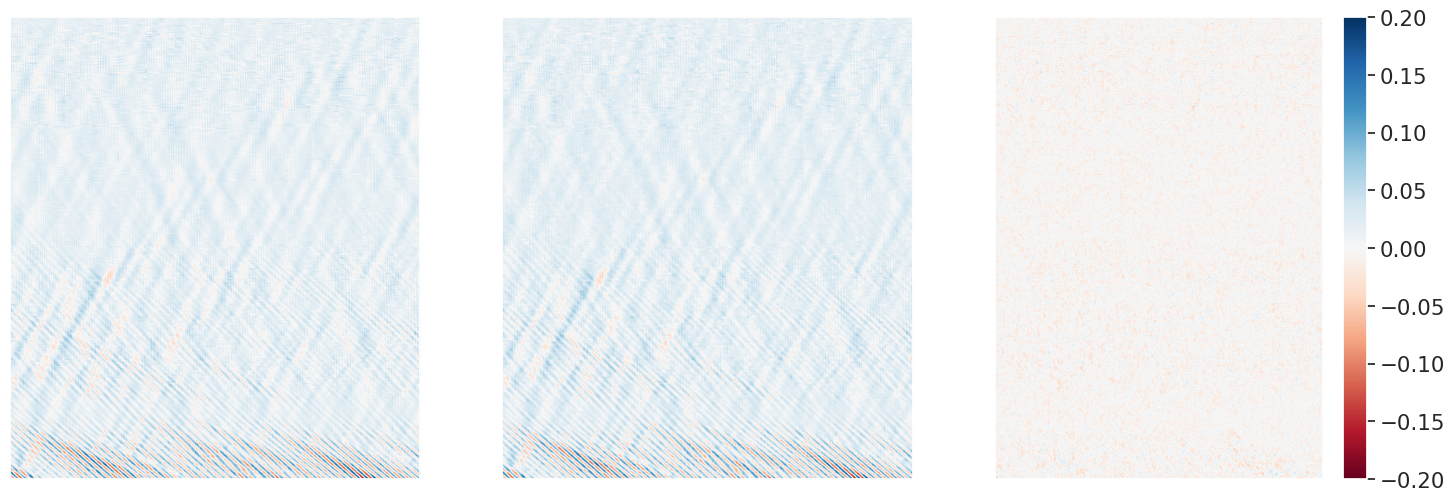

In [41]:
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -0.2, vmax = 0.2)
plt.xticks([]); plt.yticks([])
plt.colorbar()